<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-to-test-basic-functionalities" data-toc-modified-id="Notebook-to-test-basic-functionalities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook to test basic functionalities</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Simple-backtests-with-and-without-transaction-costs" data-toc-modified-id="Simple-backtests-with-and-without-transaction-costs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Simple backtests with and without transaction costs</a></span></li></ul></li></ul></div>

# Notebook to test basic functionalities

### Imports

In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
from datetime import datetime, timedelta
print("Libraries imported correctly")

Libraries imported correctly


In [3]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb

### Data

In [4]:
ini_equity_default = 100
commision_default = 2/130000 + 12.5/130000 #0.000111538462, around 0.011..% of the equity

Close  Market_daily_ret
Date                                     
2020-10-14  3488.669922         -0.006623
2020-10-15  3483.340088         -0.001528
2020-10-16  3483.810059          0.000135
2020-10-19  3426.919922         -0.016330
2020-10-20  3443.120117          0.004727

<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

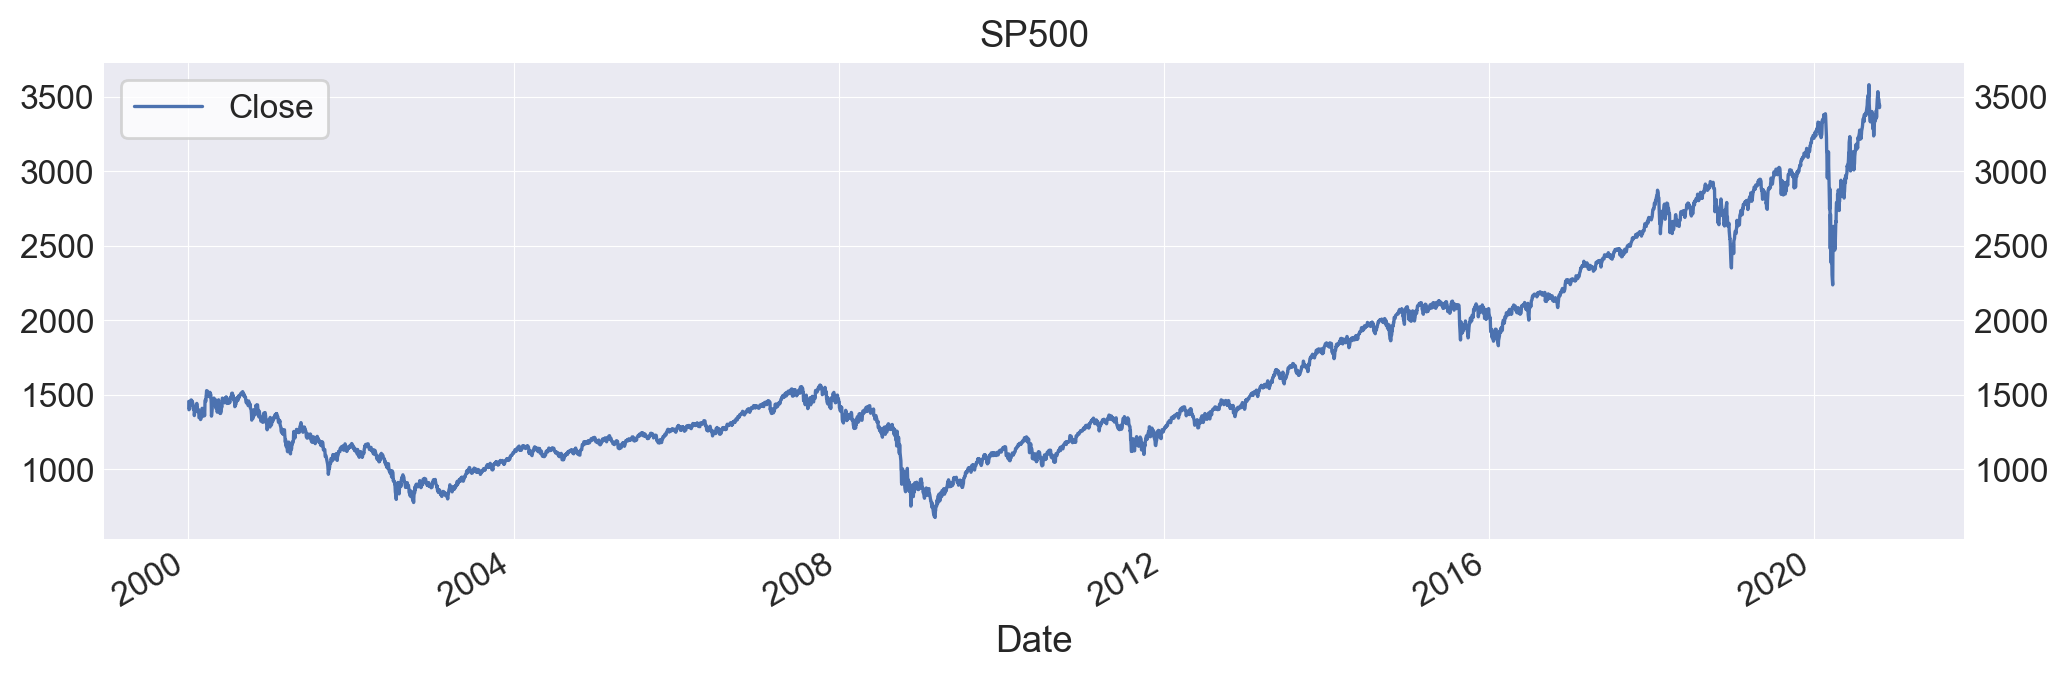

In [17]:
%run Functions.ipynb

#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data = data[['Open', 'Close']]

data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.loc['2000':'2020', ['Close', 'Market_daily_ret']]

data.tail()
data['Close'].plot(title='SP500', legend=True)

## Simple backtests with and without transaction costs

In [6]:
date_fmt = '%Y-%m-%d'
first_day = datetime.strptime('2000-01-01', date_fmt)
last_day = datetime.strptime('2020-12-31', date_fmt)
df = data.loc[first_day:last_day].copy()

In [7]:
loc = data.index.get_loc(df.index[0])
ini_money = data.iloc[loc - 1]['Close'] # We assume we can buy at the Close of the previous day to the start of the backtest
ini_money = 100
previous_position = 0

In [8]:
def sell_in_may_and_go_away(df, buy_month=0, sell_month=0, first_pos_only=False):
    if (sell_month == 0) & (sell_month == 0): # Buy and hold 
        print("buy_hold")
        return buy_and_hold(df)
    else:
        ############ start logic of the strategy ############
        df['month'] = df.index.month
        
        conditions = [(sell_month <= df['month']) & (df['month'] < buy_month)]
        signals = [0.0]
        
        position = pd.Series(np.select(conditions, signals, default=1.0), index=df.index, dtype='float64')
    
        ############ end logic of the strategy ############
    
    long_only = pd.Series(0.0, index=df.index, dtype='float64')
    
    ########## Recursive call to obtain position of the first day ##########
    if (first_pos_only == True): # This is when we want to get only the position for the first day
        return _, _, position[0]
    else: 
        loc = full_df.index.get_loc(df.index[0])
        first_position = sell_in_may_and_go_away(full_df.iloc[loc - 1].to_frame().T, buy_month, sell_month, first_pos_only=True)[2]
    
    return position, long_only, first_position

Strategy: sell_in_may_and_go_away(enter long in month 10. exit long in month 5)
Period: 2000-01-03 to 2020-10-20
	Overall return of SP500: 234.35 %. IR of SP500: 0.21
	Overall return of strategy: 264.24 %. IR strategy: 0.30


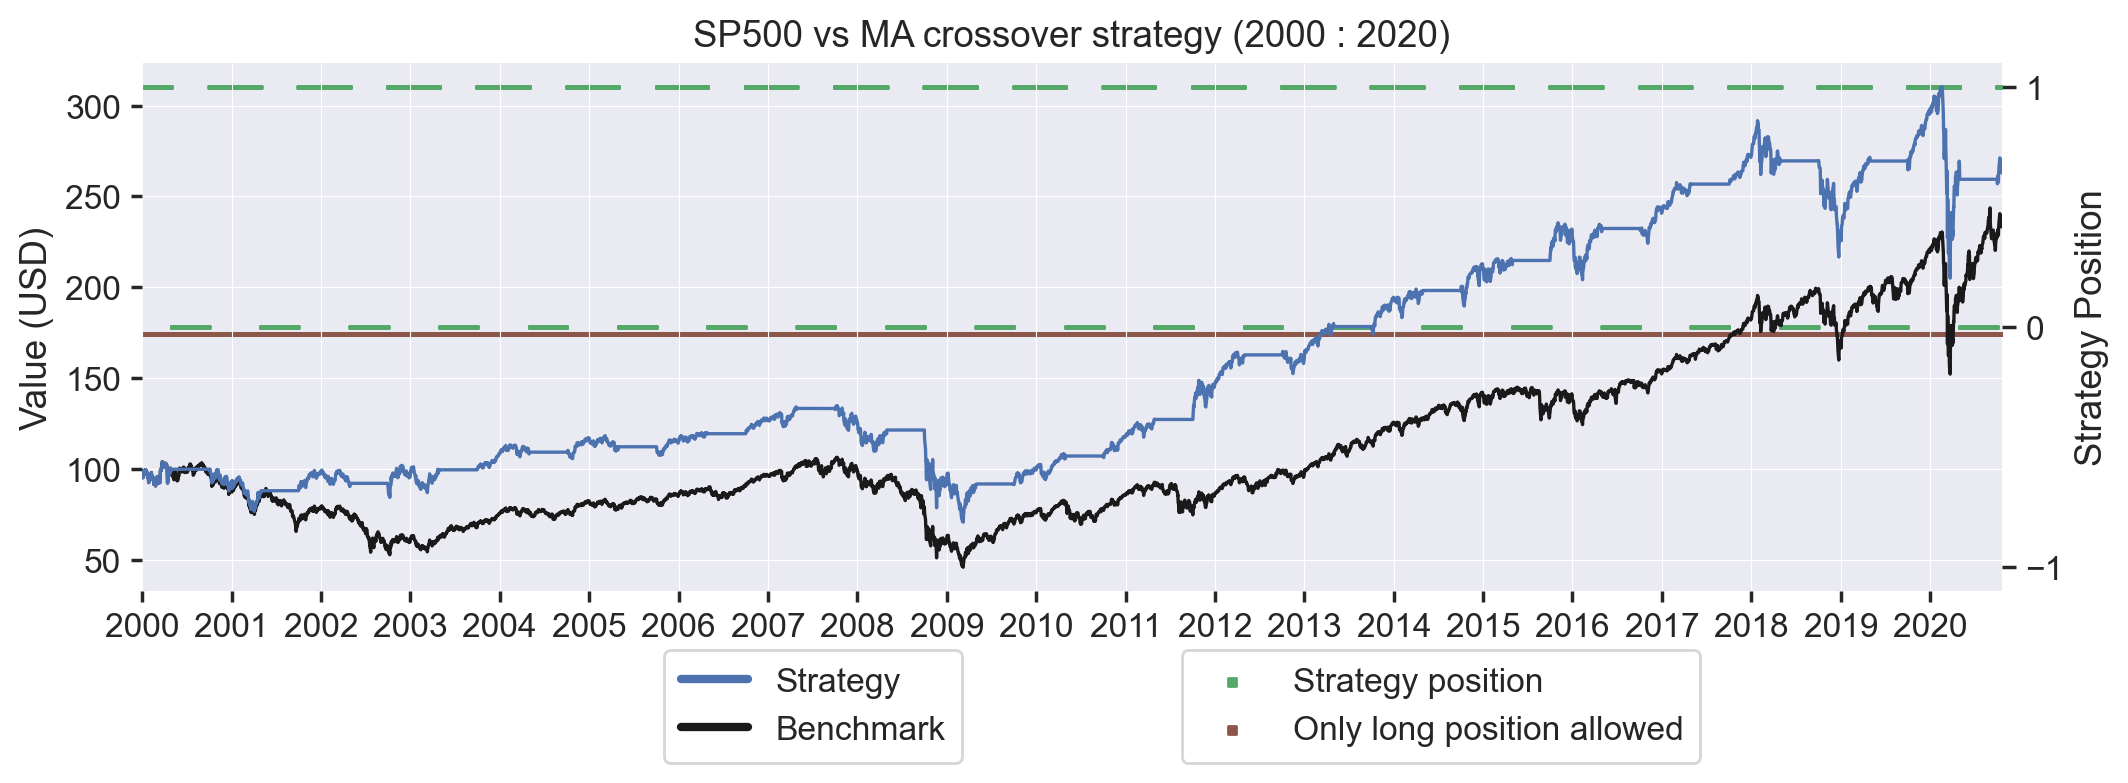

In [9]:
%run Functions.ipynb
df = data[first_day:last_day].copy()

long_month = 10 # October
sell_month = 5 # May
strategy = sell_in_may_and_go_away(df, long_month, sell_month)

df = backtest_print_plot(df, strategy, strat_name='sell_in_may_and_go_away', strat_params=(long_month, sell_month),
                         previous_position=previous_position, 
                         ini_equity=ini_money, commision=0, with_legend=True)
plt.show()

Check that we exit long position in beginning of may:

In [10]:
df.loc['2010-04-29':].head()

Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2010-04-29  1206.780029          0.012943         0.012943             1.0    0.0        0.0       82.135786     107.617451
2010-04-30  1186.689941         -0.016648        -0.016648             1.0    0.0        0.0       80.768415     105.825870
2010-05-03  1202.260010          0.013121         0.013121             0.0    0.0        0.0       81.828144     107.214367
2010-05-04  1173.599976         -0.023838         0.000000             0.0    0.0        0.0       79.877487     107.214367
2010-05-05  1165.869995         -0.006587         0.000000             0.0    0.0        0.0       79.351369     107.214367

Check that we enter long position in beginning of October:

In [11]:
df.loc['2010-09-29':].head()

Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2010-09-29  1144.729980         -0.002588         0.000000             0.0    0.0        0.0       77.912539     107.214367
2010-09-30  1141.199951         -0.003084         0.000000             0.0    0.0        0.0       77.672278     107.214367
2010-10-01  1146.239990          0.004416         0.000000             1.0    0.0        0.0       78.015313     107.214367
2010-10-04  1137.030029         -0.008035        -0.008035             1.0    0.0        0.0       77.388465     106.352907
2010-10-05  1160.750000          0.020861         0.020861             1.0    0.0        0.0       79.002893     108.571571

AbsRet     ARC      IR      aSD       MD      AMD     MLD  All Risk   ARCMD  ARCAMD  Num Trades  No signal
sell_in_may_and_go_away  164.2381  4.7895  0.2961  16.1735  47.5323  12.9070  4.0000    3.9690  0.1008  0.3711          43       2227
Buy and Hold             134.3454  4.1855  0.2101  19.9263  56.7754  16.5198  7.1732   13.4061  0.0737  0.2534           1          0

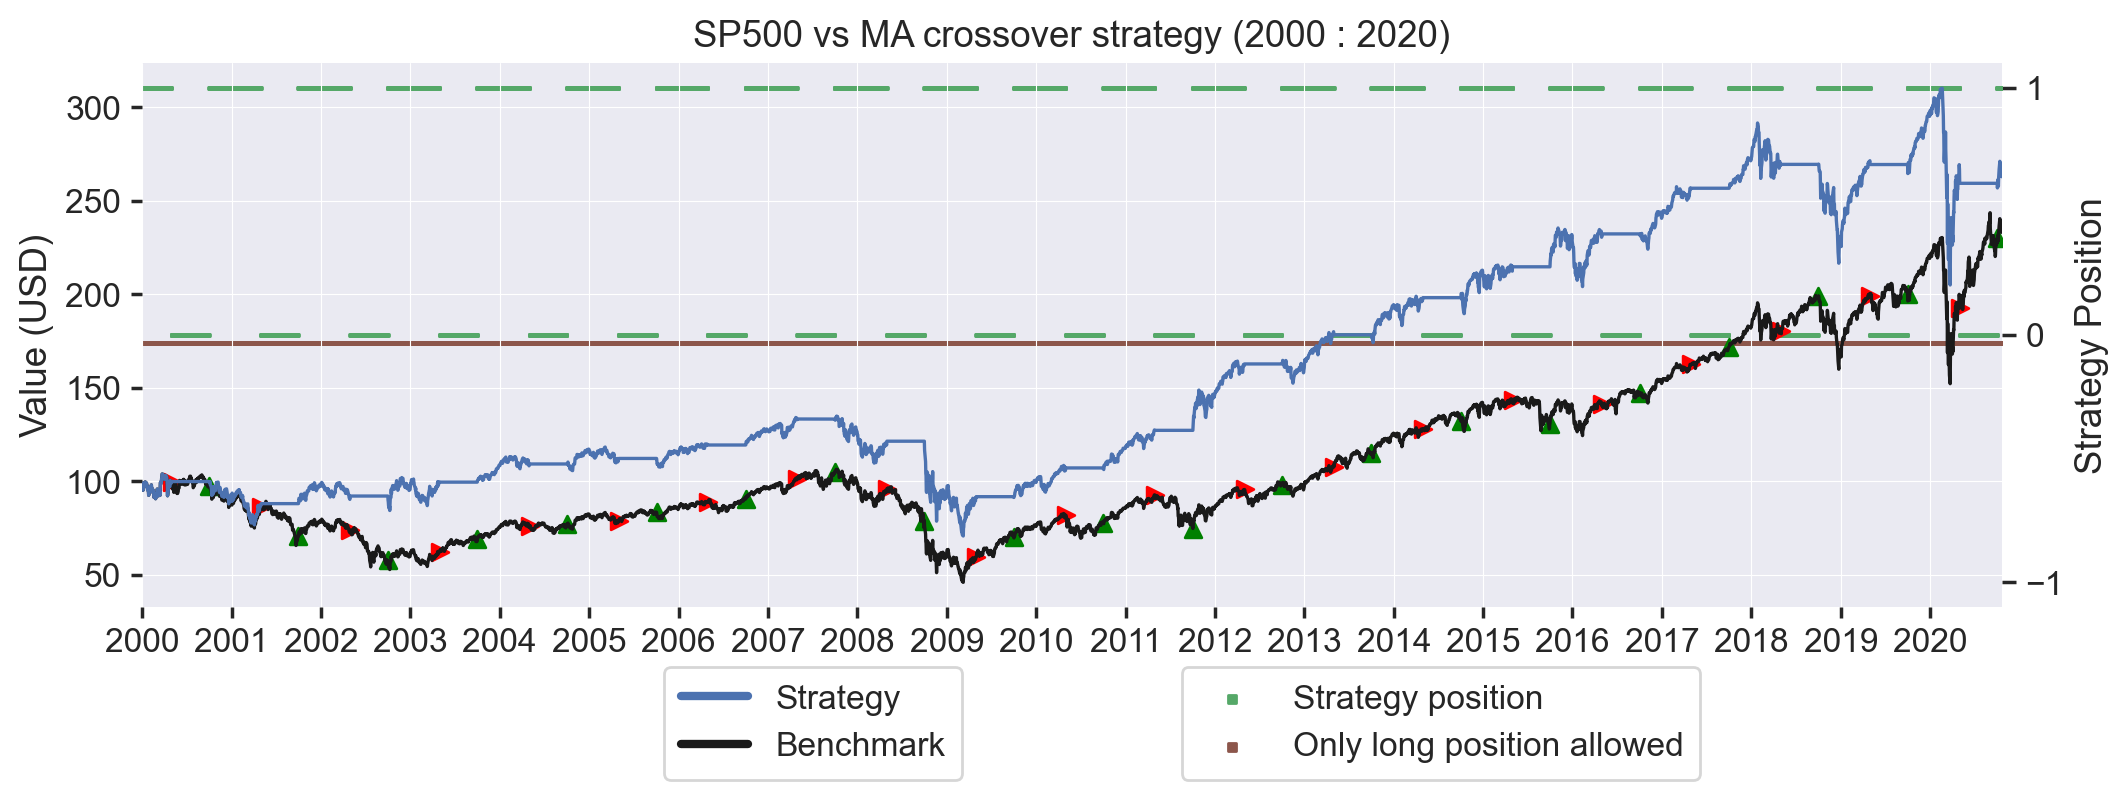

In [12]:
metrics = calculate_performance_metrics(df, strat_name='sell_in_may_and_go_away')
metrics
show_plot(df, with_legend=True, with_signals=True)